# Лекция 2: Невронни мрежи за NLP

**Продължителност:** 2-2.5 часа  
**Предпоставки:** Лекция 1 (ML основи, n-gram ограничения)  
**Следваща лекция:** Токенизация (BPE, WordPiece)

---
## Цели на лекцията

След тази лекция ще можете:

- Обяснявате защо невронните мрежи превъзхождат линейните модели за NLP
- Разбирате как работят активационните функции и защо са необходими
- Изграждате embedding слой и обяснявате какво улавят embeddings
- Изчислявате forward pass и разбирате backpropagation
- Прилагате Adam оптимизатор за обучение на текстов класификатор

### Пътна карта

```
1. Мотивация → 2. Неврони и слоеве → 3. Embeddings → 4. Forward pass
       ↓
5. Loss функции → 6. Backpropagation → 7. Оптимизатори → 8. Класификация
       ↓
9. Ограничения → 10. Обобщение
```

In [1]:
# Основни библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Настройки
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

# Възпроизводимост
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print("Библиотеките са заредени успешно.")

PyTorch version: 2.9.1
Библиотеките са заредени успешно.


---
## 1. Мотивация: От N-грами към невронни мрежи

### Какво научихме в Лекция 1?

**N-gram модели** имат три фундаментални ограничения:

| Проблем | Описание |
|---------|----------|
| **Sparsity** | Повечето n-грами имат нулев count |
| **Без генерализация** | "cat sat" и "dog sat" са напълно несвързани |
| **Къс контекст** | Bigram вижда само 1 дума назад |

### Защо линейните модели не са достатъчни?

Линеен модел: $\hat{y} = \mathbf{w}^T\mathbf{x} + b$

**Ограничения:**
- Не може да улавя взаимодействия между признаци
- Няма йерархия от представяния
- Ограничена изразителност за сложни pattern-и в текст

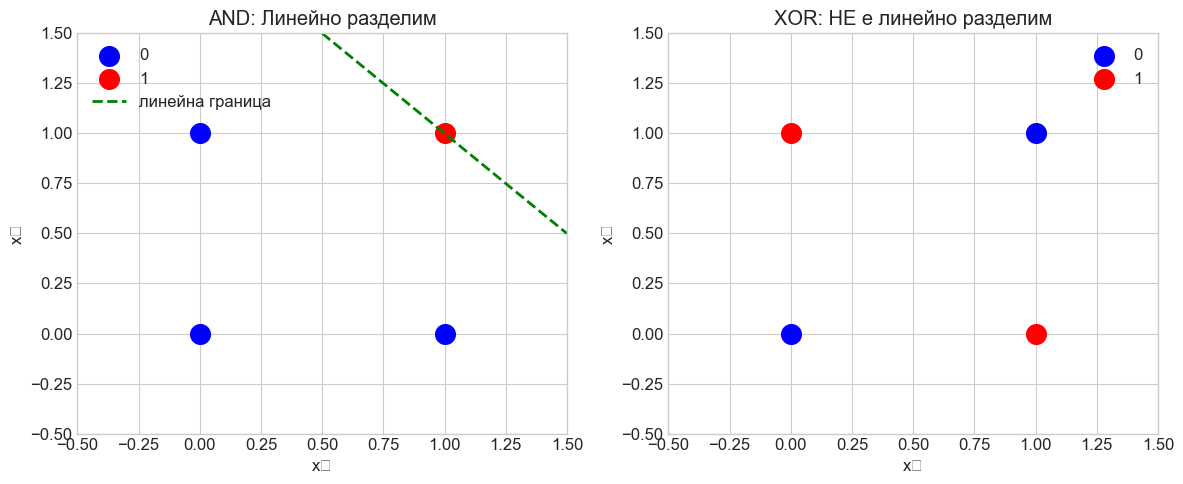

Няма права линия, която да раздели червените от сините точки в XOR.


In [2]:
# XOR проблем: линеен модел не може да го реши
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Линейно разделим случай (AND)
y_and = np.array([0, 0, 0, 1])
axes[0].scatter(X_xor[y_and==0, 0], X_xor[y_and==0, 1], c='blue', s=200, label='0')
axes[0].scatter(X_xor[y_and==1, 0], X_xor[y_and==1, 1], c='red', s=200, label='1')
axes[0].plot([0.5, 1.5], [1.5, 0.5], 'g--', linewidth=2, label='линейна граница')
axes[0].set_title('AND: Линейно разделим')
axes[0].set_xlabel('x₁'); axes[0].set_ylabel('x₂')
axes[0].legend()
axes[0].set_xlim(-0.5, 1.5); axes[0].set_ylim(-0.5, 1.5)

# XOR - не е линейно разделим
axes[1].scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], c='blue', s=200, label='0')
axes[1].scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='red', s=200, label='1')
axes[1].set_title('XOR: НЕ е линейно разделим')
axes[1].set_xlabel('x₁'); axes[1].set_ylabel('x₂')
axes[1].legend()
axes[1].set_xlim(-0.5, 1.5); axes[1].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

print("Няма права линия, която да раздели червените от сините точки в XOR.")

### Какво предлагат невронните мрежи?

| Свойство | Описание |
|----------|----------|
| **Нелинейност** | Могат да апроксимират произволни функции |
| **Йерархия** | Учат представяния на различни нива |
| **Композиция** | Прости функции → сложно поведение |

**Път към LLM:**
- Невронните мрежи са фундаментът
- Същите принципи: forward pass, backprop, optimization
- Малки мрежи → GPT с милиарди параметри

---
## 2. Градивни елементи: Неврони и слоеве

### Един неврон

**Формула:**
$$z = \sum_{i=1}^{n} w_i x_i + b = \mathbf{w}^T\mathbf{x} + b$$
$$a = f(z)$$

Където:
- $\mathbf{x}$ — входен вектор
- $\mathbf{w}$ — тегла (weights)
- $b$ — bias
- $f$ — активационна функция

In [3]:
# Демонстрация: Един неврон
def neuron(x, w, b, activation_fn):
    """Изчисляване на изхода на един неврон."""
    z = np.dot(w, x) + b
    return activation_fn(z), z

# Вход
x = np.array([0.5, -0.3, 0.8])
w = np.array([0.4, 0.6, -0.2])
b = 0.1

# ReLU активация
relu = lambda z: max(0, z)

output, z = neuron(x, w, b, relu)

print("Един неврон:")
print(f"  Вход x = {x}")
print(f"  Тегла w = {w}")
print(f"  Bias b = {b}")
print(f"\n  z = w·x + b = {z:.3f}")
print(f"  a = ReLU(z) = {output:.3f}")

Един неврон:
  Вход x = [ 0.5 -0.3  0.8]
  Тегла w = [ 0.4  0.6 -0.2]
  Bias b = 0.1

  z = w·x + b = -0.040
  a = ReLU(z) = 0.000


### Активационни функции

| Функция | Формула | Характеристики |
|---------|---------|----------------|
| **Sigmoid** | $\sigma(z) = \frac{1}{1 + e^{-z}}$ | Изход: (0, 1), vanishing gradient |
| **Tanh** | $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ | Изход: (-1, 1), zero-centered |
| **ReLU** | $\max(0, z)$ | Най-популярна, бърза, sparse |
| **GELU** | $z \cdot \Phi(z)$ | Използва се в GPT, BERT |

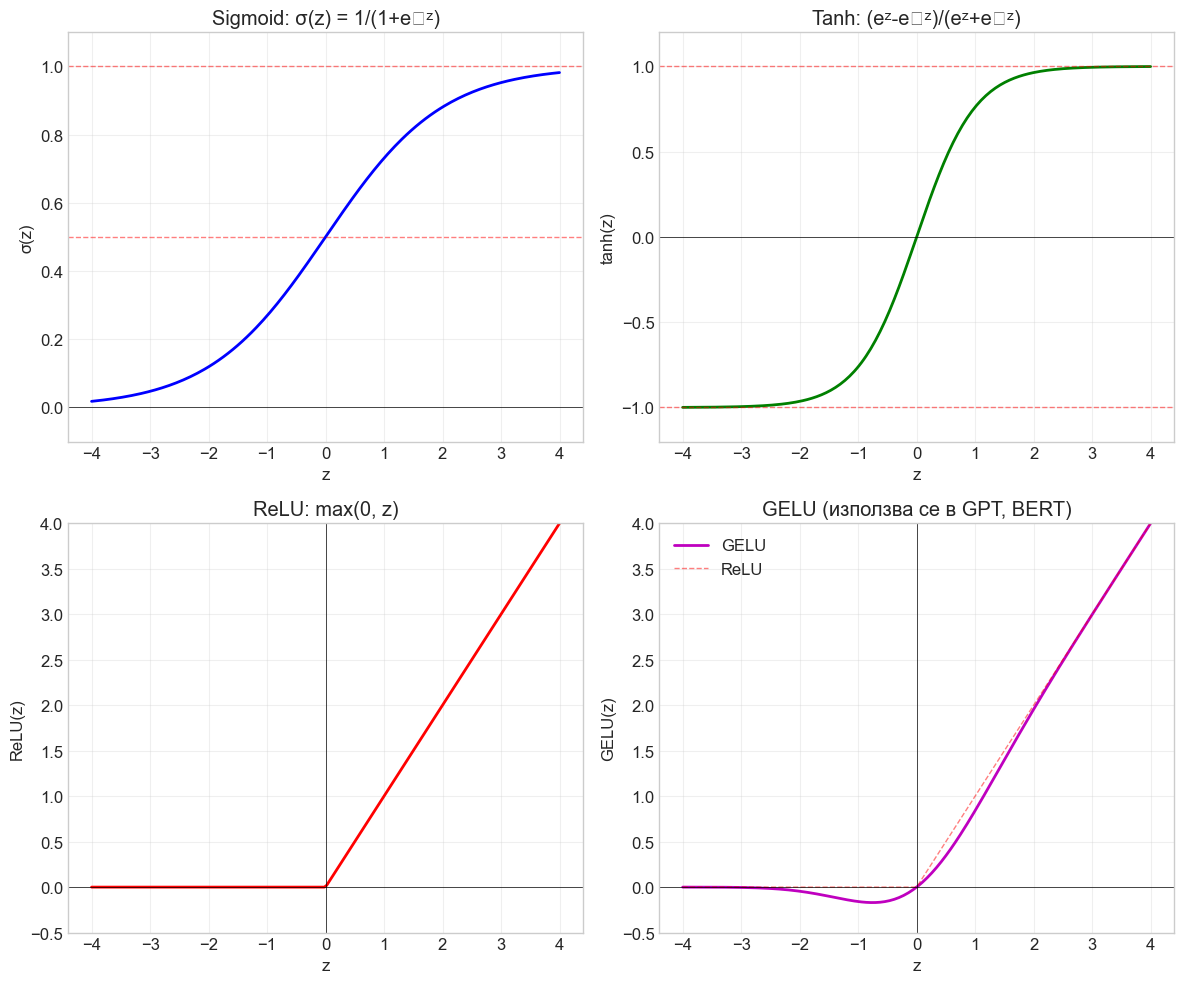

In [4]:
# Визуализация на активационни функции
z = np.linspace(-4, 4, 200)

# Дефиниции
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = np.tanh
relu = lambda x: np.maximum(0, x)
gelu = lambda x: x * 0.5 * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Sigmoid
axes[0, 0].plot(z, sigmoid(z), 'b-', linewidth=2)
axes[0, 0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0, 0].axhline(y=0.5, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].axhline(y=1, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_title('Sigmoid: σ(z) = 1/(1+e⁻ᶻ)')
axes[0, 0].set_xlabel('z'); axes[0, 0].set_ylabel('σ(z)')
axes[0, 0].set_ylim(-0.1, 1.1)
axes[0, 0].grid(True, alpha=0.3)

# Tanh
axes[0, 1].plot(z, tanh(z), 'g-', linewidth=2)
axes[0, 1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0, 1].axhline(y=-1, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].axhline(y=1, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].set_title('Tanh: (eᶻ-e⁻ᶻ)/(eᶻ+e⁻ᶻ)')
axes[0, 1].set_xlabel('z'); axes[0, 1].set_ylabel('tanh(z)')
axes[0, 1].set_ylim(-1.2, 1.2)
axes[0, 1].grid(True, alpha=0.3)

# ReLU
axes[1, 0].plot(z, relu(z), 'r-', linewidth=2)
axes[1, 0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1, 0].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[1, 0].set_title('ReLU: max(0, z)')
axes[1, 0].set_xlabel('z'); axes[1, 0].set_ylabel('ReLU(z)')
axes[1, 0].set_ylim(-0.5, 4)
axes[1, 0].grid(True, alpha=0.3)

# GELU
axes[1, 1].plot(z, gelu(z), 'm-', linewidth=2, label='GELU')
axes[1, 1].plot(z, relu(z), 'r--', linewidth=1, alpha=0.5, label='ReLU')
axes[1, 1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1, 1].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[1, 1].set_title('GELU (използва се в GPT, BERT)')
axes[1, 1].set_xlabel('z'); axes[1, 1].set_ylabel('GELU(z)')
axes[1, 1].set_ylim(-0.5, 4)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Защо нелинейността е критична?

**Без нелинейност:** Стекът от линейни слоеве е просто линеен модел.

$$f(W_2 \cdot f(W_1 \mathbf{x})) = f(W_2 W_1 \mathbf{x}) = f(W \mathbf{x})$$

**С нелинейност:** Може да апроксимира всяка непрекъсната функция (Universal Approximation Theorem).

In [5]:
# Демонстрация: Стек от линейни слоеве = един линеен слой
W1 = np.array([[1, 2], [3, 4]])
W2 = np.array([[5, 6], [7, 8]])
x = np.array([1, 1])

# Два последователни слоя без активация
h = W1 @ x           # Първи слой
y_two_layers = W2 @ h  # Втори слой

# Еквивалентен един слой
W_combined = W2 @ W1
y_one_layer = W_combined @ x

print("Без нелинейност:")
print(f"  Два слоя: W2 @ (W1 @ x) = {y_two_layers}")
print(f"  Един слой: (W2 @ W1) @ x = {y_one_layer}")
print(f"\n  Резултатите са идентични!")
print(f"  Дълбочината без нелинейност е безсмислена.")

Без нелинейност:
  Два слоя: W2 @ (W1 @ x) = [57 77]
  Един слой: (W2 @ W1) @ x = [57 77]

  Резултатите са идентични!
  Дълбочината без нелинейност е безсмислена.


### Слоеве и архитектура

| Слой | Описание |
|------|----------|
| **Входен** | Сурови признаци (embeddings за текст) |
| **Скрити** | Научени представяния |
| **Изходен** | Предсказания за задачата |

**Нотация:**
- $W^{[l]} \in \mathbb{R}^{n_l \times n_{l-1}}$ — матрица на теглата на слой $l$
- $b^{[l]} \in \mathbb{R}^{n_l}$ — bias вектор
- $a^{[l]} \in \mathbb{R}^{n_l}$ — активации

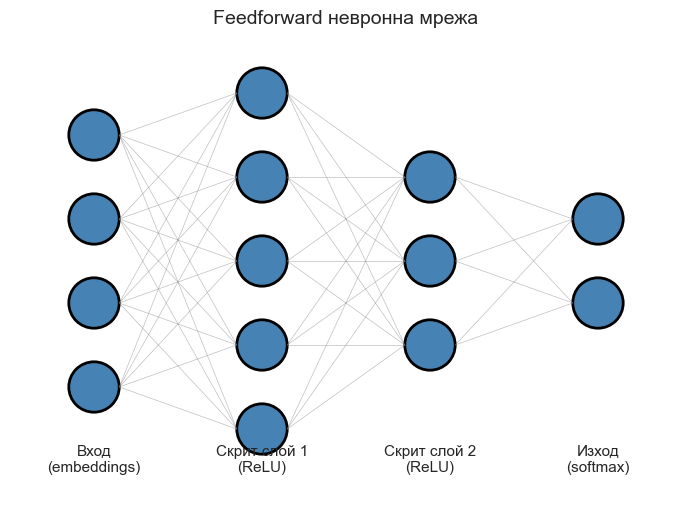

In [6]:
# Визуализация на невронна мрежа
def draw_neural_net(ax, layer_sizes, layer_names=None):
    """Рисува диаграма на невронна мрежа."""
    v_spacing = 1.0
    h_spacing = 2.0
    
    # Позиции на невроните
    for l, n in enumerate(layer_sizes):
        layer_top = v_spacing * (n - 1) / 2
        for i in range(n):
            circle = plt.Circle((l * h_spacing, layer_top - i * v_spacing),
                                0.3, color='steelblue', ec='black', linewidth=2)
            ax.add_artist(circle)
            
            # Връзки към следващия слой
            if l < len(layer_sizes) - 1:
                next_layer_top = v_spacing * (layer_sizes[l+1] - 1) / 2
                for j in range(layer_sizes[l+1]):
                    ax.plot([l * h_spacing + 0.3, (l+1) * h_spacing - 0.3],
                           [layer_top - i * v_spacing, next_layer_top - j * v_spacing],
                           'gray', linewidth=0.5, alpha=0.5)
    
    # Имена на слоевете
    if layer_names:
        for l, name in enumerate(layer_names):
            ax.text(l * h_spacing, -2.5, name, ha='center', fontsize=11)
    
    ax.set_xlim(-1, (len(layer_sizes)-1) * h_spacing + 1)
    ax.set_ylim(-3, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(12, 6))
draw_neural_net(ax, [4, 5, 3, 2], 
                ['Вход\n(embeddings)', 'Скрит слой 1\n(ReLU)', 
                 'Скрит слой 2\n(ReLU)', 'Изход\n(softmax)'])
ax.set_title('Feedforward невронна мрежа', fontsize=14, pad=20)
plt.show()

---
## 3. Embeddings: Превръщане на токени във вектори

### Проблемът

Невронните мрежи работят с числа. Текстът е последователност от дискретни символи.

**Как да свържем тези два свята?**

### One-Hot Encoding (Наивен подход)

Всяка дума = вектор с една единица.

**Проблеми:**
- Огромна размерност (50,000+ за реален речник)
- Няма семантично сходство: "cat" и "dog" са еднакво различни като "cat" и "pizza"
- Разхищение на памет

In [7]:
# One-hot демонстрация
vocab = ['cat', 'dog', 'pizza', 'happy', 'sad']
word_to_idx = {w: i for i, w in enumerate(vocab)}

def one_hot(word, vocab_size):
    vec = np.zeros(vocab_size)
    vec[word_to_idx[word]] = 1
    return vec

print("One-hot представяне:\n")
for word in vocab:
    vec = one_hot(word, len(vocab))
    print(f"  {word:6s} → {vec}")

# Сходство
cat_vec = one_hot('cat', len(vocab))
dog_vec = one_hot('dog', len(vocab))
pizza_vec = one_hot('pizza', len(vocab))

print(f"\nКосинусово сходство:")
print(f"  cat·dog = {np.dot(cat_vec, dog_vec)}")
print(f"  cat·pizza = {np.dot(cat_vec, pizza_vec)}")
print(f"\n  Всички думи са еднакво 'различни'!")

One-hot представяне:

  cat    → [1. 0. 0. 0. 0.]
  dog    → [0. 1. 0. 0. 0.]
  pizza  → [0. 0. 1. 0. 0.]
  happy  → [0. 0. 0. 1. 0.]
  sad    → [0. 0. 0. 0. 1.]

Косинусово сходство:
  cat·dog = 0.0
  cat·pizza = 0.0

  Всички думи са еднакво 'различни'!


### Научени плътни embeddings

**Идея:** Представяме всеки токен като плътен вектор с малка размерност (64-512).

**Embedding слой:** Lookup таблица $E \in \mathbb{R}^{|V| \times d}$
- $|V|$ — размер на речника
- $d$ — размерност на embedding-а

**Ключов момент:** Embedding-ите са **научени параметри**!

In [8]:
# Embedding слой от scratch
class EmbeddingLayer:
    def __init__(self, vocab_size, embed_dim):
        # Инициализираме с малки случайни стойности
        self.E = np.random.randn(vocab_size, embed_dim) * 0.1
    
    def forward(self, indices):
        """Lookup: индекс → вектор"""
        return self.E[indices]
    
    def __repr__(self):
        return f"EmbeddingLayer(vocab={self.E.shape[0]}, dim={self.E.shape[1]})"

# Пример
vocab_size = 1000
embed_dim = 64

emb = EmbeddingLayer(vocab_size, embed_dim)
print(f"{emb}")
print(f"Параметри: {vocab_size * embed_dim:,} = {vocab_size} × {embed_dim}")

# Lookup
token_idx = 42
vector = emb.forward(token_idx)
print(f"\nТокен {token_idx} → вектор с размер {vector.shape}")
print(f"Първите 8 стойности: {vector[:8].round(3)}")

EmbeddingLayer(vocab=1000, dim=64)
Параметри: 64,000 = 1000 × 64

Токен 42 → вектор с размер (64,)
Първите 8 стойности: [ 0.076  0.061 -0.102 -0.024 -0.004 -0.013  0.033  0.143]


In [9]:
# PyTorch embedding слой
embedding = nn.Embedding(num_embeddings=1000, embedding_dim=64)

# Lookup за batch от токени
token_indices = torch.tensor([5, 42, 100, 7])
vectors = embedding(token_indices)

print(f"Вход: {token_indices.tolist()}")
print(f"Изход shape: {vectors.shape}  (batch_size × embed_dim)")
print(f"\nПараметри на embedding слоя: {embedding.weight.numel():,}")

Вход: [5, 42, 100, 7]
Изход shape: torch.Size([4, 64])  (batch_size × embed_dim)

Параметри на embedding слоя: 64,000


### Какво улавят embeddings?

След обучение:
- **Сходни думи → сходни вектори**
- Семантични релации са кодирани геометрично
- Косинусово сходство: $\text{sim}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}|| \cdot ||\mathbf{v}||}$

In [10]:
# Косинусово сходство
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Симулираме "обучени" embeddings
# В реалност това би дошло от обучен модел
embeddings_dict = {
    'cat': np.array([0.5, 0.3, -0.2, 0.8]),
    'dog': np.array([0.4, 0.4, -0.1, 0.7]),
    'pizza': np.array([-0.3, 0.8, 0.5, -0.1]),
    'pasta': np.array([-0.2, 0.7, 0.6, -0.2]),
}

print("Косинусово сходство (хипотетични embeddings):\n")
words = list(embeddings_dict.keys())
for i, w1 in enumerate(words):
    for w2 in words[i+1:]:
        sim = cosine_similarity(embeddings_dict[w1], embeddings_dict[w2])
        print(f"  {w1:6s} ↔ {w2:6s}: {sim:.3f}")

print("\n  cat≈dog (животни), pizza≈pasta (храна)")

Косинусово сходство (хипотетични embeddings):

  cat    ↔ dog   : 0.984
  cat    ↔ pizza : -0.090
  cat    ↔ pasta : -0.175
  dog    ↔ pizza : 0.089
  dog    ↔ pasta : -0.000
  pizza  ↔ pasta : 0.980

  cat≈dog (животни), pizza≈pasta (храна)


---
## 4. Forward Pass: Правене на предсказания

### Изчисляване слой по слой

**Слой 1:**
$$z^{[1]} = W^{[1]}\mathbf{x} + b^{[1]}$$
$$a^{[1]} = f(z^{[1]})$$

**Слой 2:**
$$z^{[2]} = W^{[2]}a^{[1]} + b^{[2]}$$
$$a^{[2]} = f(z^{[2]})$$

**Изход:**
$$\hat{y} = a^{[L]}$$

In [11]:
# Forward pass от scratch
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward_pass(x, weights, biases):
    """Forward pass през мрежа с ReLU + Sigmoid изход."""
    activations = [x]
    a = x
    
    # Скрити слоеве с ReLU
    for i in range(len(weights) - 1):
        z = weights[i] @ a + biases[i]
        a = relu(z)
        activations.append(a)
    
    # Изходен слой със Sigmoid
    z = weights[-1] @ a + biases[-1]
    a = sigmoid(z)
    activations.append(a)
    
    return a, activations

# Примерна мрежа: 4 → 3 → 2 → 1
np.random.seed(42)
W1 = np.random.randn(3, 4) * 0.5
b1 = np.zeros(3)
W2 = np.random.randn(2, 3) * 0.5
b2 = np.zeros(2)
W3 = np.random.randn(1, 2) * 0.5
b3 = np.zeros(1)

weights = [W1, W2, W3]
biases = [b1, b2, b3]

# Вход (например средно embedding на изречение)
x = np.array([0.5, -0.3, 0.8, 0.1])

output, activations = forward_pass(x, weights, biases)

print("Forward pass:\n")
print(f"  Вход x:     {x} (размер: {x.shape})")
print(f"  Слой 1 a¹:  {activations[1].round(3)} (размер: {activations[1].shape})")
print(f"  Слой 2 a²:  {activations[2].round(3)} (размер: {activations[2].shape})")
print(f"  Изход ŷ:    {output.round(3)} (вероятност)")

Forward pass:

  Вход x:     [ 0.5 -0.3  0.8  0.1] (размер: (4,))
  Слой 1 a¹:  [0.48  0.647 0.   ] (размер: (3,))
  Слой 2 a²:  [0. 0.] (размер: (2,))
  Изход ŷ:    [0.5] (вероятност)


### Матрична нотация за batch обработка

Вместо да обработваме примери един по един:

$$X \in \mathbb{R}^{m \times n}$$ — m примера, n признака

$$Z^{[1]} = XW^{[1]T} + b^{[1]}$$

**Защо batch?**
- GPU ускорение чрез паралелизъм
- По-стабилни градиенти
- Един и същ код за един пример или хиляди

In [12]:
# Batch forward pass с PyTorch
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Модел
model = SimpleNet(input_dim=64, hidden_dim=32, output_dim=1)

# Batch от 8 примера с 64 признака
batch = torch.randn(8, 64)

output = model(batch)
print(f"Вход shape: {batch.shape}")
print(f"Изход shape: {output.shape}")
print(f"\nПредсказания за batch-а:")
print(f"  {output.squeeze().detach().numpy().round(3)}")

Вход shape: torch.Size([8, 64])
Изход shape: torch.Size([8, 1])

Предсказания за batch-а:
  [0.7   0.64  0.651 0.599 0.577 0.636 0.657 0.58 ]


---
## 5. Loss функции и проблемът за обучение

### Binary Cross-Entropy

За бинарна класификация:

$$L = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log(\hat{y}^{(i)}) + (1-y^{(i)})\log(1-\hat{y}^{(i)})]$$

**Интуиция:** Наказваме увереност в грешни предсказания.

| Истина | Предсказание | Loss |
|--------|--------------|------|
| y=1 | ŷ=0.9 | -log(0.9) = 0.105 (нисък) |
| y=1 | ŷ=0.1 | -log(0.1) = 2.303 (висок) |

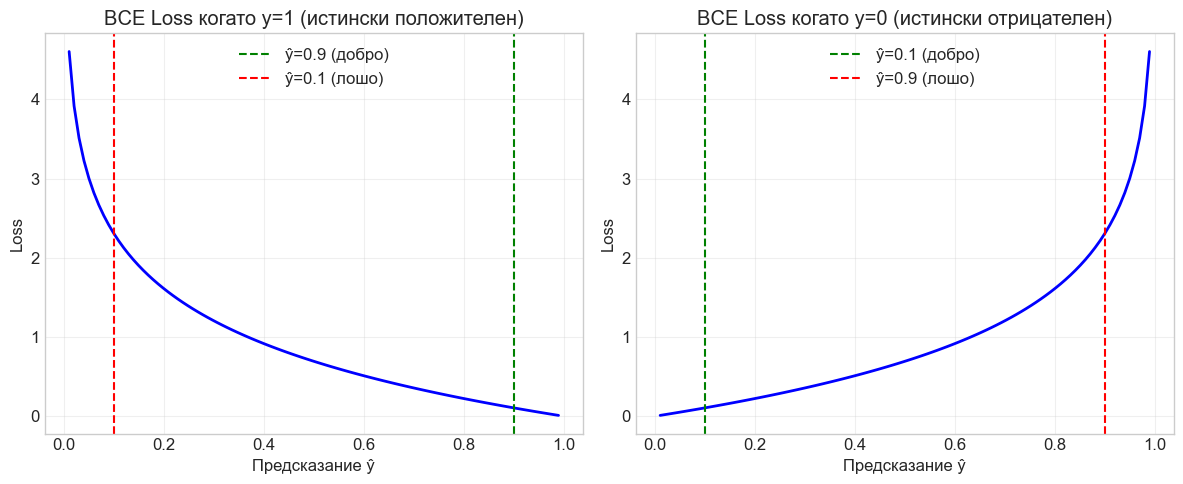

In [13]:
# Binary Cross-Entropy визуализация
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15  # Избягваме log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

y_pred = np.linspace(0.01, 0.99, 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Когато y=1
loss_y1 = binary_cross_entropy(1, y_pred)
axes[0].plot(y_pred, loss_y1, 'b-', linewidth=2)
axes[0].set_xlabel('Предсказание ŷ')
axes[0].set_ylabel('Loss')
axes[0].set_title('BCE Loss когато y=1 (истински положителен)')
axes[0].axvline(x=0.9, color='g', linestyle='--', label='ŷ=0.9 (добро)')
axes[0].axvline(x=0.1, color='r', linestyle='--', label='ŷ=0.1 (лошо)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Когато y=0
loss_y0 = binary_cross_entropy(0, y_pred)
axes[1].plot(y_pred, loss_y0, 'b-', linewidth=2)
axes[1].set_xlabel('Предсказание ŷ')
axes[1].set_ylabel('Loss')
axes[1].set_title('BCE Loss когато y=0 (истински отрицателен)')
axes[1].axvline(x=0.1, color='g', linestyle='--', label='ŷ=0.1 (добро)')
axes[1].axvline(x=0.9, color='r', linestyle='--', label='ŷ=0.9 (лошо)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Multi-class Cross-Entropy (Categorical)

**Softmax:** Превръща logits във вероятности.

$$\hat{y}_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$$

**Loss:**
$$L = -\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{K} y_j^{(i)} \log(\hat{y}_j^{(i)})$$

**Критично за LLM:** Next-token prediction използва точно тази loss!

Softmax преобразуване:

  Logits: [2.  1.  0.1]
  Probs:  [0.659 0.242 0.099]
  Sum:    1.000


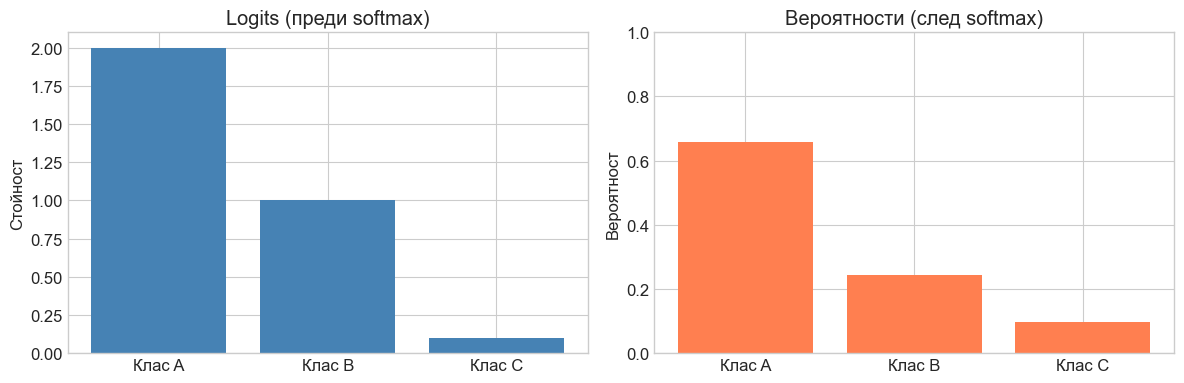

In [14]:
# Softmax демонстрация
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Numerical stability
    return exp_z / exp_z.sum()

# Logits от модел (преди softmax)
logits = np.array([2.0, 1.0, 0.1])
probs = softmax(logits)

print("Softmax преобразуване:\n")
print(f"  Logits: {logits}")
print(f"  Probs:  {probs.round(3)}")
print(f"  Sum:    {probs.sum():.3f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

classes = ['Клас A', 'Клас B', 'Клас C']

axes[0].bar(classes, logits, color='steelblue')
axes[0].set_ylabel('Стойност')
axes[0].set_title('Logits (преди softmax)')

axes[1].bar(classes, probs, color='coral')
axes[1].set_ylabel('Вероятност')
axes[1].set_title('Вероятности (след softmax)')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Loss като оптимизационен проблем

**Цел:** $\min_{\theta} L(\theta)$

Където $\theta = \{W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]}, ..., E\}$

**Важно:** Embedding матрицата $E$ също са научени параметри!

**Защо не можем да решим аналитично?**
- Нелинейни активации
- Non-convex loss landscape
- Милиони/милиарди параметри

---
## 6. Backpropagation: Изчисляване на градиенти

### Идеята на градиентно спускане

**Правило за обновяване:**
$$\theta := \theta - \alpha \nabla_\theta L$$

Където $\alpha$ е learning rate.

**Проблем:** Как да изчислим $\nabla_\theta L$ ефективно за милиони параметри?

### Chain Rule интуиция

За да намерим $\frac{\partial L}{\partial W^{[1]}}$, прилагаме chain rule:

$$\frac{\partial L}{\partial W^{[1]}} = \frac{\partial L}{\partial a^{[2]}} \cdot \frac{\partial a^{[2]}}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial a^{[1]}} \cdot \frac{\partial a^{[1]}}{\partial z^{[1]}} \cdot \frac{\partial z^{[1]}}{\partial W^{[1]}}$$

**Ключов insight:** Работим от изхода към входа и преизползваме изчисления.

In [15]:
# Backpropagation за проста 2-слойна мрежа
def simple_backprop_demo():
    """Демонстрация на backprop за мрежа: вход → скрит (ReLU) → изход (sigmoid)."""
    np.random.seed(42)
    
    # Данни: 1 пример
    x = np.array([0.5, 0.3])  # Вход
    y = 1.0  # Етикет
    
    # Параметри
    W1 = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # 3x2
    b1 = np.array([0.1, 0.1, 0.1])
    W2 = np.array([[0.1, 0.2, 0.3]])  # 1x3
    b2 = np.array([0.1])
    
    # === FORWARD PASS ===
    z1 = W1 @ x + b1
    a1 = np.maximum(0, z1)  # ReLU
    z2 = W2 @ a1 + b2
    y_hat = 1 / (1 + np.exp(-z2))  # Sigmoid
    
    # Loss
    loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    print("=== FORWARD PASS ===")
    print(f"x = {x}")
    print(f"z1 = W1·x + b1 = {z1.round(3)}")
    print(f"a1 = ReLU(z1) = {a1.round(3)}")
    print(f"z2 = W2·a1 + b2 = {z2.round(3)}")
    print(f"ŷ = sigmoid(z2) = {y_hat.round(3)}")
    print(f"Loss = {loss[0].round(4)}")
    
    # === BACKWARD PASS ===
    # dL/dz2 = ŷ - y (за sigmoid + BCE)
    dz2 = y_hat - y
    
    # dL/dW2 = dz2 · a1^T
    dW2 = dz2.reshape(-1, 1) @ a1.reshape(1, -1)
    db2 = dz2
    
    # dL/da1 = W2^T · dz2
    da1 = W2.T @ dz2
    
    # dL/dz1 = da1 * ReLU'(z1)
    dz1 = da1.flatten() * (z1 > 0).astype(float)  # ReLU derivative
    
    # dL/dW1 = dz1 · x^T
    dW1 = dz1.reshape(-1, 1) @ x.reshape(1, -1)
    db1 = dz1
    
    print("\n=== BACKWARD PASS ===")
    print(f"dL/dz2 = {dz2.round(4)}")
    print(f"dL/dW2 = \n{dW2.round(4)}")
    print(f"dL/dW1 = \n{dW1.round(4)}")
    
    return {'dW1': dW1, 'dW2': dW2, 'db1': db1, 'db2': db2}

grads = simple_backprop_demo()

=== FORWARD PASS ===
x = [0.5 0.3]
z1 = W1·x + b1 = [0.21 0.37 0.53]
a1 = ReLU(z1) = [0.21 0.37 0.53]
z2 = W2·a1 + b2 = [0.354]
ŷ = sigmoid(z2) = [0.588]
Loss = 0.5317

=== BACKWARD PASS ===
dL/dz2 = [-0.4124]
dL/dW2 = 
[[-0.0866 -0.1526 -0.2186]]
dL/dW1 = 
[[-0.0206 -0.0124]
 [-0.0412 -0.0247]
 [-0.0619 -0.0371]]


In [16]:
# PyTorch autograd - автоматично изчисляване на градиенти
x = torch.tensor([0.5, 0.3], requires_grad=False)
y = torch.tensor([1.0])

# Параметри (същите като горе)
W1 = torch.tensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]], requires_grad=True)
b1 = torch.tensor([0.1, 0.1, 0.1], requires_grad=True)
W2 = torch.tensor([[0.1, 0.2, 0.3]], requires_grad=True)
b2 = torch.tensor([0.1], requires_grad=True)

# Forward
z1 = W1 @ x + b1
a1 = F.relu(z1)
z2 = W2 @ a1 + b2
y_hat = torch.sigmoid(z2)

# Loss
loss = F.binary_cross_entropy(y_hat, y)

# Backward (автоматично!)
loss.backward()

print("PyTorch Autograd:\n")
print(f"Loss: {loss.item():.4f}")
print(f"\ndW2 (PyTorch) = \n{W2.grad.numpy().round(4)}")
print(f"dW2 (ръчно)   = \n{grads['dW2'].round(4)}")
print(f"\nГрадиентите съвпадат: {np.allclose(W2.grad.numpy(), grads['dW2'], atol=1e-4)}")

PyTorch Autograd:

Loss: 0.5317

dW2 (PyTorch) = 
[[-0.0866 -0.1526 -0.2186]]
dW2 (ръчно)   = 
[[-0.0866 -0.1526 -0.2186]]

Градиентите съвпадат: True


### Градиенти за embeddings

**Ключов момент:** Embedding lookup е диференцируем!

- Градиентът се разпространява обратно към embedding векторите
- Обновяват се само embeddings за токените в текущия batch
- Sparse updates: ефективно за големи речници

In [17]:
# Градиенти за embeddings
vocab_size = 100
embed_dim = 8

embedding = nn.Embedding(vocab_size, embed_dim)

# Само 3 токена в batch-а
token_ids = torch.tensor([5, 23, 42])

# Forward: вземаме embeddings и ги sumираме (опростено)
embeds = embedding(token_ids)
output = embeds.sum()

# Backward
output.backward()

# Проверяваме кои редове имат ненулеви градиенти
grad_norms = embedding.weight.grad.norm(dim=1)
nonzero_indices = (grad_norms > 0).nonzero().flatten().tolist()

print("Embedding градиенти:\n")
print(f"Токени в batch-а: {token_ids.tolist()}")
print(f"Редове с ненулеви градиенти: {nonzero_indices}")
print(f"\nОстаналите {vocab_size - len(nonzero_indices)} embedding-а НЕ се обновяват.")

Embedding градиенти:

Токени в batch-а: [5, 23, 42]
Редове с ненулеви градиенти: [5, 23, 42]

Останалите 97 embedding-а НЕ се обновяват.


---
## 7. Оптимизационни алгоритми

### Stochastic Gradient Descent (SGD)

$$\theta := \theta - \alpha \nabla_\theta L^{(i)}$$

**Свойства:**
- Шумни обновления (висока variance)
- Може да избяга от shallow local minima
- Бавна конвергенция

Learning rate $\alpha$ е критичен: прекалено висок → дивергенция, прекалено нисък → бавно.

### SGD с Momentum

$$v := \beta v + (1-\beta)\nabla_\theta L$$
$$\theta := \theta - \alpha v$$

**Интуиция:** Топка, която се търкаля надолу — натрупва скорост.

Типично $\beta = 0.9$.

### Adam (Adaptive Moment Estimation)

Комбинира momentum + adaptive learning rates:

$$m := \beta_1 m + (1-\beta_1)\nabla_\theta L$$ (първи момент)
$$v := \beta_2 v + (1-\beta_2)(\nabla_\theta L)^2$$ (втори момент)
$$\hat{m} = m/(1-\beta_1^t), \quad \hat{v} = v/(1-\beta_2^t)$$ (bias correction)
$$\theta := \theta - \alpha \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}$$

**Default стойности:** $\beta_1=0.9$, $\beta_2=0.999$, $\alpha=0.001$

**Защо Adam е доминиращ:** Адаптивен, робустен, работи добре на практика.

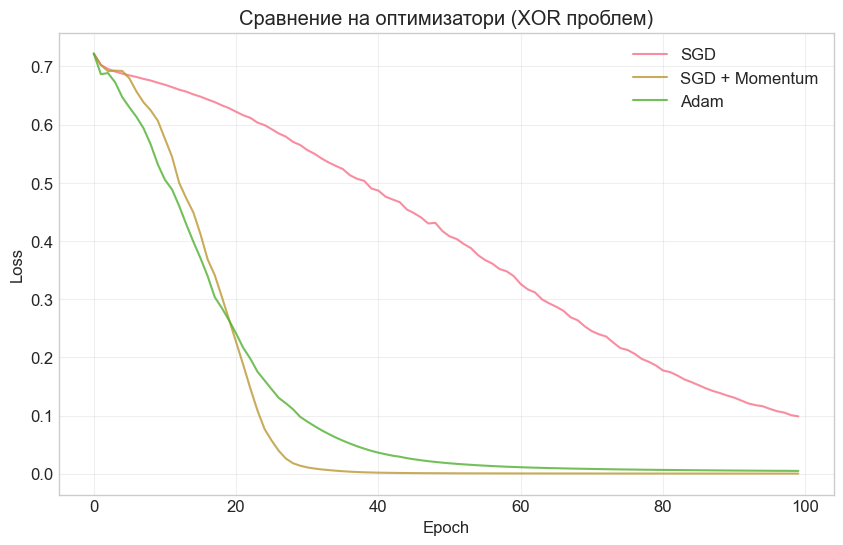

Финален loss:
  SGD:      0.0986
  Momentum: 0.0003
  Adam:     0.0048


In [18]:
# Сравнение на оптимизатори
def train_with_optimizer(optimizer_class, lr, epochs=100):
    """Обучава проста мрежа с даден оптимизатор."""
    torch.manual_seed(42)
    
    # Синтетични данни (XOR проблем)
    X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
    y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
    
    # Модел
    model = nn.Sequential(
        nn.Linear(2, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Sigmoid()
    )
    
    optimizer = optimizer_class(model.parameters(), lr=lr)
    losses = []
    
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = F.binary_cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses

# Сравнение
sgd_losses = train_with_optimizer(torch.optim.SGD, lr=0.5)
momentum_losses = train_with_optimizer(
    lambda p, lr: torch.optim.SGD(p, lr=lr, momentum=0.9), lr=0.5)
adam_losses = train_with_optimizer(torch.optim.Adam, lr=0.1)

plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, label='SGD', alpha=0.8)
plt.plot(momentum_losses, label='SGD + Momentum', alpha=0.8)
plt.plot(adam_losses, label='Adam', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Сравнение на оптимизатори (XOR проблем)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Финален loss:")
print(f"  SGD:      {sgd_losses[-1]:.4f}")
print(f"  Momentum: {momentum_losses[-1]:.4f}")
print(f"  Adam:     {adam_losses[-1]:.4f}")

### AdamW: Weight Decay Fix

Adam с правилно weight decay (L2 регуляризация).

**Използва се във всички модерни LLM:** GPT, BERT, LLaMA, Claude.

---
## 8. Обучение и текстова класификация

### Mini-Batch обучение

| Режим | Примери | Свойства |
|-------|---------|----------|
| Full batch | Всички | Бавно, точен градиент |
| Single | 1 | Много шумен |
| Mini-batch | 32-256 | Баланс, GPU ефективен |

**Epoch:** Един пълен преход през тренировъчните данни.

### Архитектура за текстова класификация

**Проблем:** Изреченията имат различна дължина.

**Решение:** Pooling на embeddings към фиксиран размер.

```
Вход: изречение
  ↓ Tokenize
Токени: [token_1, token_2, ..., token_n]
  ↓ Embedding lookup
Embeddings: [batch_size, seq_len, embed_dim]
  ↓ Mean Pooling
Pooled: [batch_size, embed_dim]
  ↓ Linear + ReLU
Hidden: [batch_size, hidden_dim]
  ↓ Dropout
  ↓ Linear + Sigmoid/Softmax
Output: [batch_size, num_classes]
```

In [19]:
# Зареждане на IMDB dataset
from sklearn.datasets import fetch_openml

# Използваме subset за бързина
print("Зареждане на IMDB dataset...")

# Малък примерен dataset (за демо)
reviews = [
    "This movie was absolutely fantastic! Great acting and plot.",
    "Terrible film. Waste of time. Don't watch it.",
    "I loved every minute of this masterpiece.",
    "Boring and predictable. Very disappointing.",
    "One of the best movies I've ever seen!",
    "Awful acting and terrible script.",
    "A wonderful cinematic experience.",
    "I couldn't finish watching. So bad.",
    "Excellent direction and beautiful cinematography.",
    "Not worth your time or money.",
    "Amazing performances by the entire cast.",
    "Poorly written and badly directed.",
    "A must-see film for everyone.",
    "Disappointing sequel that fails to deliver.",
    "Brilliantly crafted with attention to detail.",
    "The worst movie of the year.",
] * 50  # Repeat for more data

labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] * 50

# Shuffle
indices = np.random.permutation(len(reviews))
reviews = [reviews[i] for i in indices]
labels = [labels[i] for i in indices]

print(f"Общо ревюта: {len(reviews)}")
print(f"Положителни: {sum(labels)}, Отрицателни: {len(labels) - sum(labels)}")
print(f"\nПример: '{reviews[0][:50]}...' → {labels[0]}")

Зареждане на IMDB dataset...
Общо ревюта: 800
Положителни: 400, Отрицателни: 400

Пример: 'Excellent direction and beautiful cinematography....' → 1


In [20]:
# Изграждане на речник
import re

def simple_tokenize(text):
    """Проста токенизация: lowercase + split по не-букви."""
    text = text.lower()
    tokens = re.findall(r'\b[a-z]+\b', text)
    return tokens

# Изграждаме речник от топ думи
word_counts = Counter()
for review in reviews:
    word_counts.update(simple_tokenize(review))

# Запазваме топ 5000 думи
vocab_size = 5000
special_tokens = ['<pad>', '<unk>']
vocab = special_tokens + [w for w, _ in word_counts.most_common(vocab_size - len(special_tokens))]
word_to_idx = {w: i for i, w in enumerate(vocab)}

print(f"Размер на речника: {len(vocab)}")
print(f"Топ 10 думи: {vocab[2:12]}")

Размер на речника: 81
Топ 10 думи: ['and', 'the', 'of', 'i', 'movie', 'acting', 'terrible', 'this', 'disappointing', 'to']


In [21]:
# Dataset клас
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len=50):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len
        self.pad_idx = word_to_idx['<pad>']
        self.unk_idx = word_to_idx['<unk>']
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = simple_tokenize(self.texts[idx])
        
        # Convert to indices
        indices = [self.word_to_idx.get(t, self.unk_idx) for t in tokens]
        
        # Padding/truncation
        if len(indices) < self.max_len:
            indices = indices + [self.pad_idx] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        
        return (
            torch.tensor(indices, dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

# Разделяне на данните
train_texts, val_texts, train_labels, val_labels = train_test_split(
    reviews, labels, test_size=0.2, random_state=42
)

train_dataset = SentimentDataset(train_texts, train_labels, word_to_idx)
val_dataset = SentimentDataset(val_texts, val_labels, word_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

# Пример
x, y = train_dataset[0]
print(f"\nПример вход shape: {x.shape}")
print(f"Етикет: {y.item()}")

Train: 640, Val: 160

Пример вход shape: torch.Size([50])
Етикет: 0.0


In [22]:
# Модел за текстова класификация
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx, dropout=0.3):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        
        # Embedding lookup
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # Mean pooling (игнорираме padding)
        mask = (x != 0).unsqueeze(-1).float()  # [batch_size, seq_len, 1]
        embedded = embedded * mask
        pooled = embedded.sum(dim=1) / mask.sum(dim=1).clamp(min=1)  # [batch_size, embed_dim]
        
        # Feedforward
        hidden = F.relu(self.fc1(pooled))
        hidden = self.dropout(hidden)
        output = torch.sigmoid(self.fc2(hidden))
        
        return output.squeeze(-1)

# Създаваме модел
model = TextClassifier(
    vocab_size=len(vocab),
    embed_dim=64,
    hidden_dim=128,
    output_dim=1,
    pad_idx=word_to_idx['<pad>']
)

print(model)
print(f"\nОбщо параметри: {sum(p.numel() for p in model.parameters()):,}")

TextClassifier(
  (embedding): Embedding(81, 64, padding_idx=0)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Общо параметри: 13,633


In [23]:
# Обучение
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in loader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = (y_pred > 0.5).float()
        correct += (predictions == y).sum().item()
        total += y.size(0)
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            
            total_loss += loss.item()
            predictions = (y_pred > 0.5).float()
            correct += (predictions == y).sum().item()
            total += y.size(0)
    
    return total_loss / len(loader), correct / total

# Настройки
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Обучение...\n")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Acc={train_acc:.3f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.3f}")

Обучение...

Epoch  5: Train Loss=0.0426, Acc=1.000 | Val Loss=0.0291, Acc=1.000
Epoch 10: Train Loss=0.0052, Acc=1.000 | Val Loss=0.0037, Acc=1.000
Epoch 15: Train Loss=0.0018, Acc=1.000 | Val Loss=0.0014, Acc=1.000
Epoch 20: Train Loss=0.0009, Acc=1.000 | Val Loss=0.0007, Acc=1.000


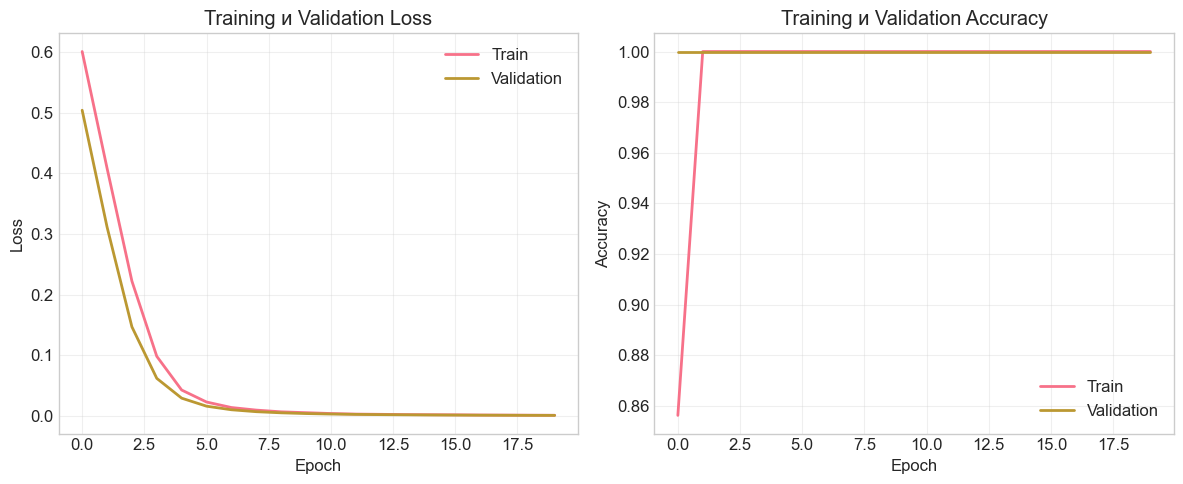

In [24]:
# Визуализация на training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training и Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train', linewidth=2)
axes[1].plot(val_accs, label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training и Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Интерпретация на training curves

| Сценарий | Характеристика | Действие |
|----------|----------------|----------|
| **Добро** | Train ≈ Val, и двете намаляват | Продължи обучението |
| **Overfitting** | Train ↓, Val ↑ | Dropout, early stopping, повече данни |
| **Underfitting** | И двете високи | По-голям модел, повече epochs |

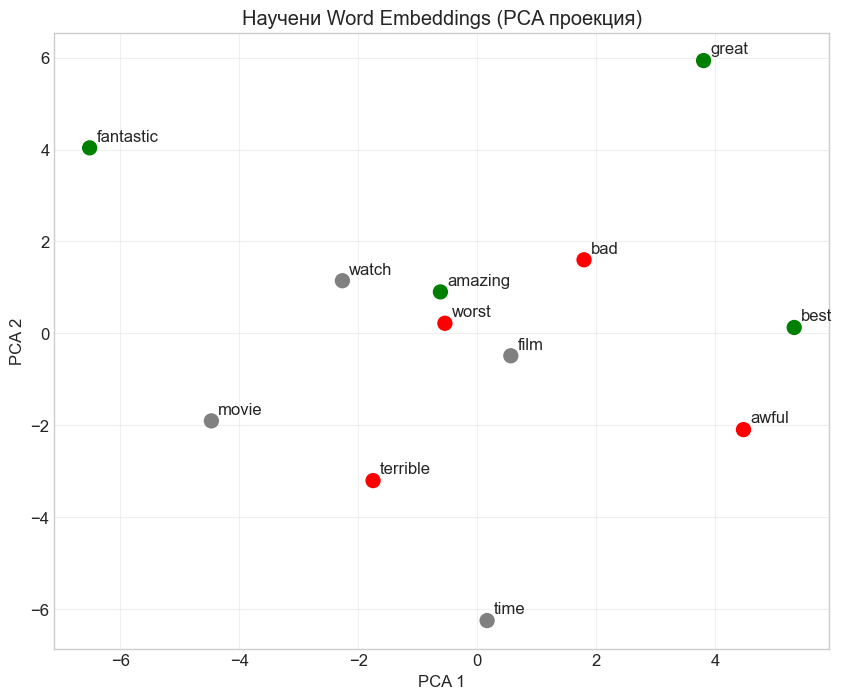

Зелено: положителни думи, Червено: отрицателни, Сиво: неутрални


In [25]:
# Визуализация на научените embeddings
selected_words = ['great', 'fantastic', 'amazing', 'terrible', 'awful', 'bad',
                  'movie', 'film', 'watch', 'time', 'best', 'worst']

# Вземаме embeddings за избрани думи
word_vectors = []
valid_words = []
for word in selected_words:
    if word in word_to_idx:
        idx = word_to_idx[word]
        vec = model.embedding.weight[idx].detach().numpy()
        word_vectors.append(vec)
        valid_words.append(word)

word_vectors = np.array(word_vectors)

# PCA за 2D визуализация
pca = PCA(n_components=2)
coords = pca.fit_transform(word_vectors)

# Цветове: положителни думи = зелено, отрицателни = червено, неутрални = сиво
positive = ['great', 'fantastic', 'amazing', 'best']
negative = ['terrible', 'awful', 'bad', 'worst']

colors = []
for w in valid_words:
    if w in positive:
        colors.append('green')
    elif w in negative:
        colors.append('red')
    else:
        colors.append('gray')

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c=colors, s=100)

for i, word in enumerate(valid_words):
    plt.annotate(word, (coords[i, 0], coords[i, 1]), fontsize=12,
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Научени Word Embeddings (PCA проекция)')
plt.grid(True, alpha=0.3)
plt.show()

print("Зелено: положителни думи, Червено: отрицателни, Сиво: неутрални")

---
## 9. Ограничения и мост към следващата лекция

### Какво този подход НЕ може да обработи добре

**1. Дълги зависимости:**
- "The movie started well but the ending was terrible"
- Mean pooling губи тази структура

**2. Ред на думите:**
- "not good" vs "good" — pooling не улавя negation
- Bag-of-embeddings е order-invariant

**3. Непознати думи (OOV):**
- Какво правим с дума, която не е в речника?
- Проста токенизация има ограничен речник

In [26]:
# Демонстрация на ограничения
test_pairs = [
    ("This movie is good", "This movie is not good"),
    ("Absolutely fantastic film", "Absolutely terrible film"),
]

model.eval()
print("Проблем с negation и контекст:\n")

for sent1, sent2 in test_pairs:
    # Tokenize и predict
    def predict(text):
        tokens = simple_tokenize(text)
        indices = [word_to_idx.get(t, word_to_idx['<unk>']) for t in tokens]
        indices = indices + [0] * (50 - len(indices))
        x = torch.tensor([indices])
        with torch.no_grad():
            return model(x).item()
    
    p1 = predict(sent1)
    p2 = predict(sent2)
    
    print(f"  '{sent1}'")
    print(f"    → P(positive) = {p1:.3f}")
    print(f"  '{sent2}'")
    print(f"    → P(positive) = {p2:.3f}")
    print()

Проблем с negation и контекст:

  'This movie is good'
    → P(positive) = 0.569
  'This movie is not good'
    → P(positive) = 0.140

  'Absolutely fantastic film'
    → P(positive) = 0.998
  'Absolutely terrible film'
    → P(positive) = 0.960



### Проблемът с токенизацията

- **Какво е "дума"?** "New York" — една концепция, два токена?
- **Контракции:** "don't" — една дума или две?
- **Нови думи:** "chatgpt", "cryptocurrency"
- **Грешки:** "gooood", "loooove"

**Следваща лекция:** BPE, WordPiece и subword tokenization.

### Ключови изводи

1. **Невронните мрежи учат представяния от данни**
   - Нелинейност е критична
   - Embeddings улавят семантично сходство

2. **Backpropagation + оптимизация**
   - Chain rule за градиенти
   - Adam е стандарт за deep learning

3. **Същите принципи мащабират до LLM**
   - Forward pass, loss, backward, update
   - Милиони → милиарди параметри

4. **Но:** Нуждаем се от по-добра токенизация и моделиране на последователности

### Следваща лекция: Токенизация

**Въпроси, на които ще отговорим:**
- Как дефинираме токени? Какви са алтернативите на думи?
- Какво е BPE (Byte Pair Encoding)?
- Как GPT и BERT токенизират?
- Защо токенизацията е критична за многоезични модели?

**Защо е важно:**
- GPT използва BPE с ~50K токени
- Токенизацията определя какво "вижда" моделът
- Грешна токенизация → лоша производителност

---
## Ресурси

### Статии
1. Rumelhart, Hinton, Williams (1986) — "Learning representations by back-propagating errors"
2. Kingma & Ba (2014) — "Adam: A Method for Stochastic Optimization"
3. Srivastava et al. (2014) — "Dropout: A Simple Way to Prevent Neural Networks from Overfitting"

### Учебници
1. Goodfellow, Bengio, Courville — "Deep Learning", Chapter 6, 8
2. Michael Nielsen — "Neural Networks and Deep Learning" (free online)
3. Jurafsky & Martin — "Speech and Language Processing", Chapter 7

### Online
1. Stanford CS231n — Backpropagation notes
2. Stanford CS224N — Lecture 3
3. 3Blue1Brown — Neural Network video series
4. PyTorch tutorials

---
## Упражнения

### Упражнение 1: Имплементирайте мрежа от scratch
- Изградете 2-слойна мрежа в NumPy (без frameworks)
- Имплементирайте forward pass, backprop, SGD
- Обучете на XOR проблема
- Верифицирайте градиентите с PyTorch

### Упражнение 2: Изследване на embeddings
- Обучете класификатор на IMDB
- Извлечете научените embeddings
- Намерете най-близки съседи за избрани думи
- Визуализирайте с t-SNE

### Упражнение 3: Сравнение на оптимизатори
- Обучете един и същ класификатор с SGD, Momentum, Adam
- Сравнете скоростта на конвергенция
- Експериментирайте с различни learning rates

### Упражнение 4: Диагностика на обучение
- Дадени са няколко training runs (някои добри, някои лоши)
- Идентифицирайте: overfitting, underfitting, лош learning rate
- Предложете и приложете fixes

---
## Край на Лекция 2

**Въпроси?**

---

**Следваща лекция:** Токенизация (BPE, WordPiece, subword алгоритми)